In [ ]:
# ✅ Import all required libraries for Bat & Ball Detection (CPU setup)

# Core ML and YOLO
import torch
from ultralytics import YOLO

# OpenCV for video processing, drawing, and speed estimation
import cv2

# Data handling and math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm

# ✅ Check environment setup
print("🔍 Checking library versions...\n")
print(f"Torch version: {torch.__version__}")
print(f"YOLO (Ultralytics) version: {YOLO.__module__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

print(f"Seaborn version: {sns.__version__}")

# ✅ Final check
print("\n✅ All libraries imported successfully and environment is ready for use!")


🔍 Checking library versions...

Torch version: 2.8.0+cu126
YOLO (Ultralytics) version: ultralytics.models.yolo.model
OpenCV version: 4.12.0
Numpy version: 2.0.2
Pandas version: 2.2.2
Seaborn version: 0.13.2

✅ All libraries imported successfully and environment is ready for use!


In [ ]:
# ============================================
# 📦 Cricket Bat & Ball Detection (YOLOv8)
# ============================================

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Set base path
BASE_PATH = "/content/drive/MyDrive/ball detection"

# ✅ Verify folder structure
import os
print(os.listdir(BASE_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Proposal.docx', 'Proposal.pdf', 'detection_and_tracking.ipynb', 'detection_tracking_speed.ipynb', 'videos', 'datasets', 'vedios', 'utils', 'notebooks', 'app', 'runs']


In [ ]:
yaml_path = f"{BASE_PATH}/datasets/data.yaml"

# Ensure file exists
assert os.path.exists(yaml_path), f"❌ data.yaml not found at: {yaml_path}"

# Display YAML content
with open(yaml_path, "r") as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['ball', 'bat']

roboflow:
  workspace: sports-edi15
  project: detection-mvn6z
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/sports-edi15/detection-mvn6z/dataset/2


In [ ]:
from ultralytics import YOLO
import os

# ✅ Define your Google Drive path (already mounted)
drive_path = '/content/drive/MyDrive/yolo_training/'  # you can rename this folder if you want

# Create directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# ✅ Load YOLOv8n model
model = YOLO('yolov8n.pt')

In [ ]:
# ============================================
# 🏏 Cricket Bat & Ball Detection (YOLOv8n)
# ============================================

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Set base path
BASE_PATH = "/content/drive/MyDrive/ball detection"

# ✅ Verify folder structure
import os
print(os.listdir(BASE_PATH))

# ✅ Create runs folder
RUNS_PATH = os.path.join(BASE_PATH, "runs")
os.makedirs(RUNS_PATH, exist_ok=True)

# ✅ Create a smaller temporary dataset for quick training
import shutil, random, glob

# Original dataset folders
orig_train_img = os.path.join(BASE_PATH, "datasets/train/images")
orig_train_lbl = os.path.join(BASE_PATH, "datasets/train/labels")

# Create small dataset folders
sample_dataset = "/content/sample_dataset"
os.makedirs(f"{sample_dataset}/train/images", exist_ok=True)
os.makedirs(f"{sample_dataset}/train/labels", exist_ok=True)
os.makedirs(f"{sample_dataset}/val/images", exist_ok=True)
os.makedirs(f"{sample_dataset}/val/labels", exist_ok=True)

# ✅ Select random subset of images (e.g. 4000 images for fine-tuning)
num_samples = 5000
all_imgs = glob.glob(os.path.join(orig_train_img, "*.jpg")) + glob.glob(os.path.join(orig_train_img, "*.png"))
sample_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

# ✅ Copy selected images and labels
for img_path in sample_imgs:
    lbl_path = img_path.replace("/images/", "/labels/").rsplit('.', 1)[0] + ".txt"
    if os.path.exists(lbl_path):
        shutil.copy(img_path, f"{sample_dataset}/train/images/")
        shutil.copy(lbl_path, f"{sample_dataset}/train/labels/")

# ✅ Split 15% data for validation
val_ratio = 0.15
val_count = int(len(sample_imgs) * val_ratio)
val_imgs = random.sample(sample_imgs, val_count)

for img_path in val_imgs:
    base_img_name = os.path.basename(img_path)
    lbl_path = img_path.replace("/images/", "/labels/").rsplit('.', 1)[0] + ".txt"
    img_train_path = os.path.join(f"{sample_dataset}/train/images", base_img_name)
    lbl_train_path = os.path.join(f"{sample_dataset}/train/labels", os.path.basename(lbl_path))
    if os.path.exists(img_train_path) and os.path.exists(lbl_train_path):
        shutil.move(img_train_path, f"{sample_dataset}/val/images/{base_img_name}")
        shutil.move(lbl_train_path, f"{sample_dataset}/val/labels/{os.path.basename(lbl_path)}")

# ✅ Create data.yaml for YOLO
yaml_content = f"""
train: {sample_dataset}/train
val: {sample_dataset}/val
nc: 2
names: ['bat', 'ball']
"""

yaml_path = f"{sample_dataset}/data.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

# ✅ Import YOLO
from ultralytics import YOLO

# ✅ Load YOLOv8n model (nano)
model = YOLO("yolov8n.pt")

# ✅ Train model — checkpoints & best.pt saved in Drive
results = model.train(
    data=yaml_path,
    epochs=50,
    # quick fine-tuning
    imgsz=640,
    batch=8,
    workers=2,
    device=0,                    # GPU (T4)
    name='cric_detect_train_bat_ball_sample',
    project=RUNS_PATH,
    save_period=5                # saves weights every 2 epochs
)

print("✅ Training complete! All results saved to:", RUNS_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Proposal.docx', 'Proposal.pdf', 'detection_and_tracking.ipynb', 'detection_tracking_speed.ipynb', 'videos', 'datasets', 'vedios', 'utils', 'notebooks', 'app', 'runs']
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/sample_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1

In [ ]:
# Evaluate model performance on validation set
metrics = model.val()
metrics.box.map, metrics.box.map50, metrics.box.map75


Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1831.2±925.3 MB/s, size: 103.8 KB)
val: Scanning /content/sample_dataset/val/labels.cache... 1312 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1312/1312 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 82/82 5.0it/s 16.3s
                   all       1312       1319      0.884       0.72      0.828        0.5
                   bat       1312       1319      0.884       0.72      0.828        0.5
Speed: 1.2ms preprocess, 2.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/runs/detect/val


(np.float64(0.5002173004679739),
 np.float64(0.8284496837298246),
 np.float64(0.5371999927335912))

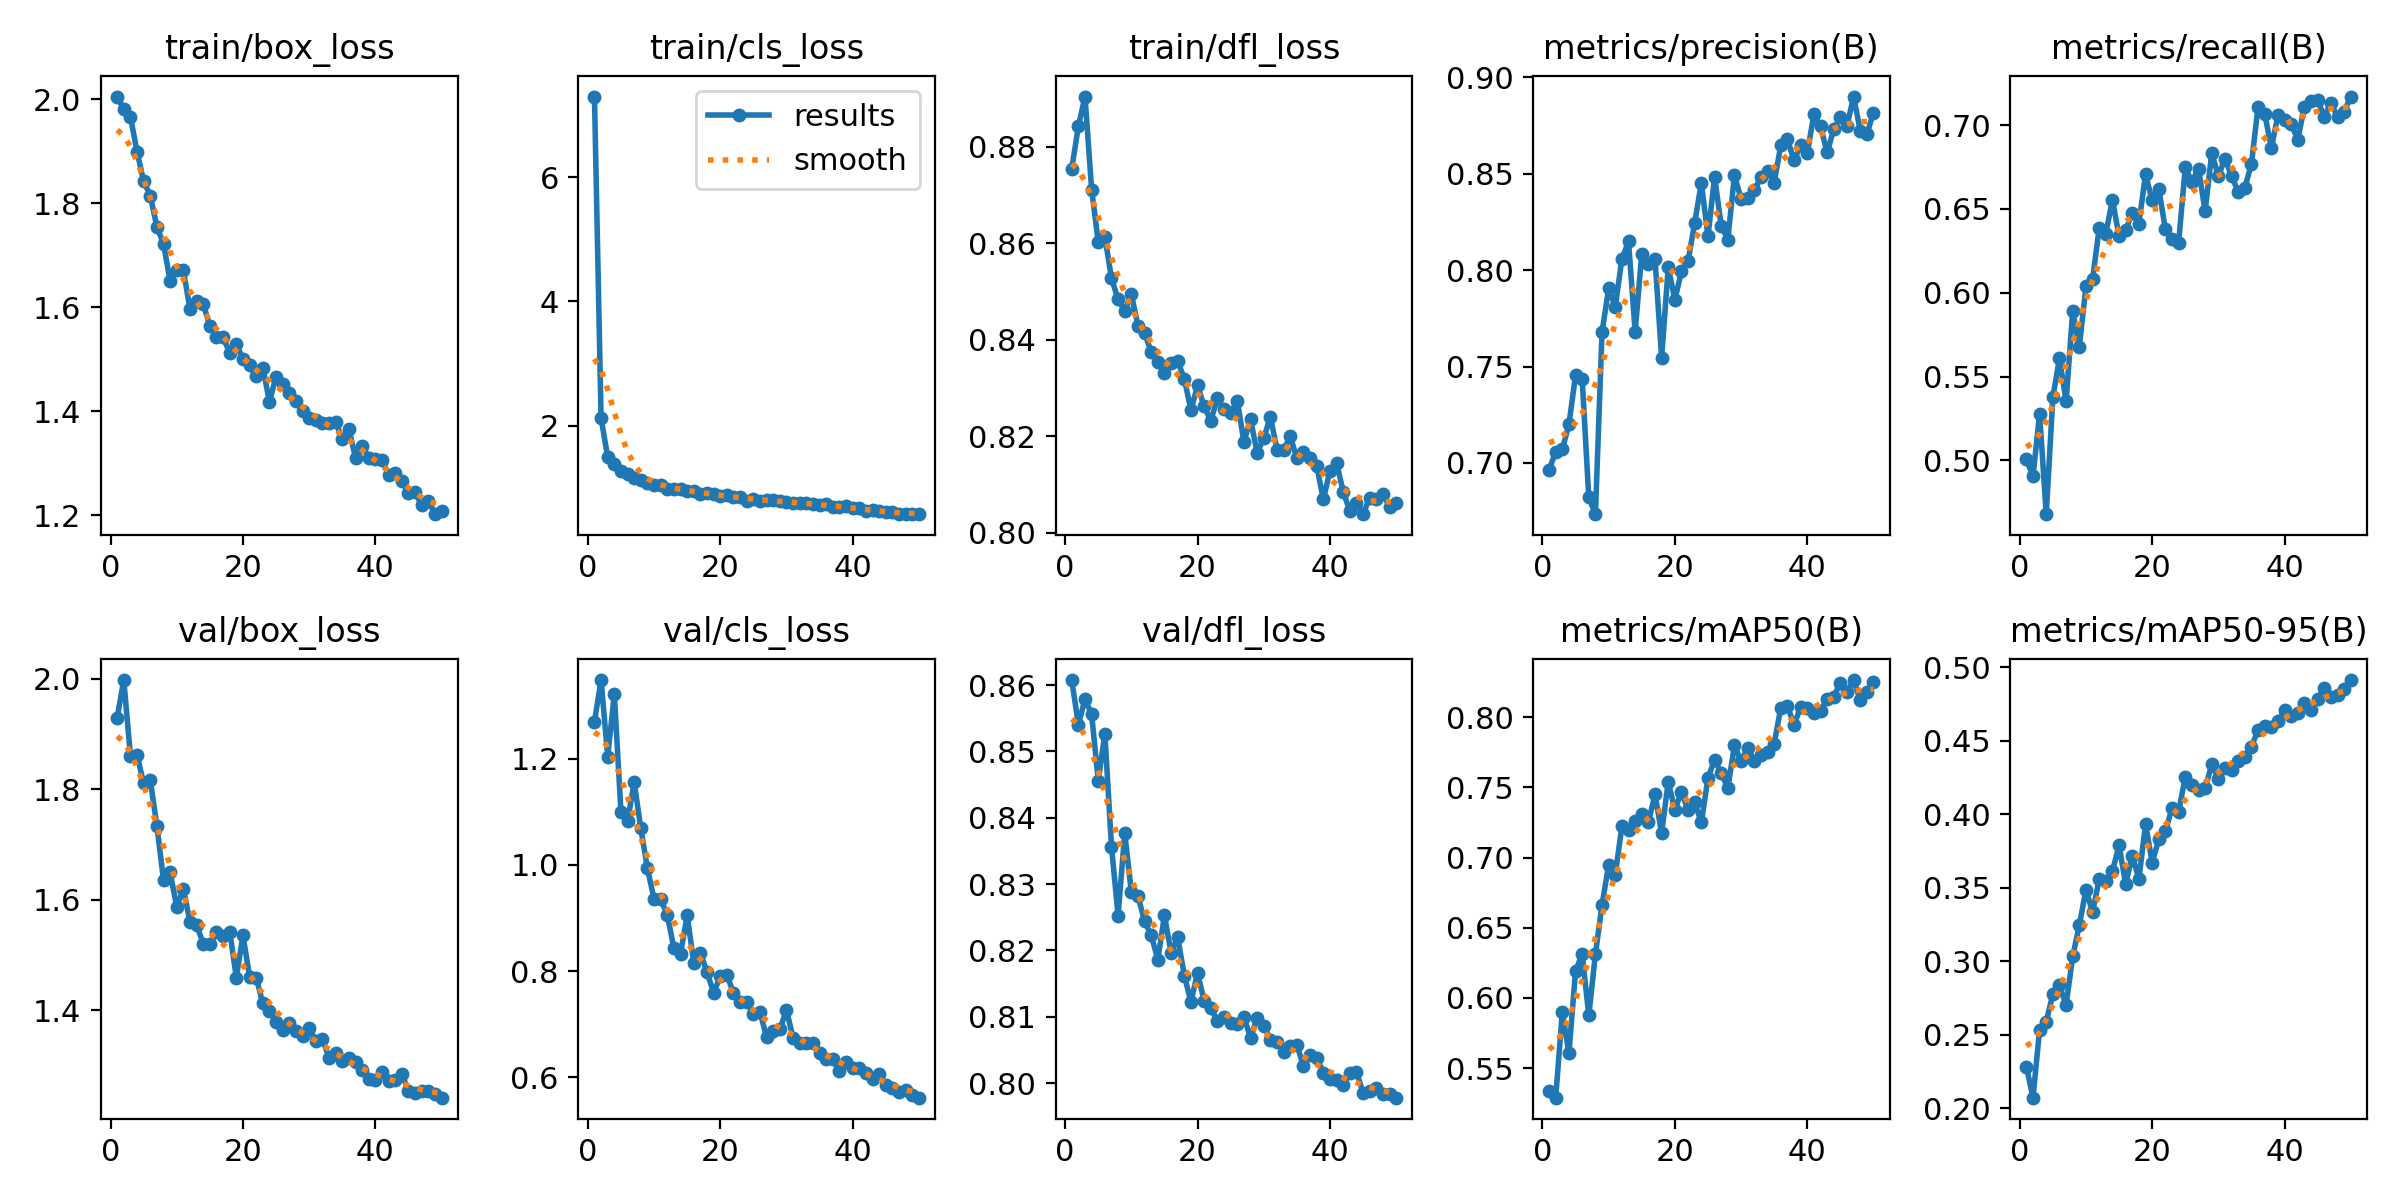

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image

# Correct path to the results image
results_img_path = os.path.join(RUNS_PATH, "cric_detect_train_bat_ball_sample2", "results.png")

# Display the training results
Image(filename=results_img_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_PATH = "/content/drive/MyDrive/ball detection"


In [ ]:

# Load trained YOLOv8 model
model_path = os.path.join(BASE_PATH, "runs", "cric_detect_train_bat_ball_sample2", "weights", "best.pt")
model = YOLO(model_path)

In [ ]:

test_image = os.path.join(BASE_PATH, "datasets", "test", "images", "scene02637_jpg.rf.712127697b246abc684edfbe49ee5b1b.jpg")



In [ ]:
import os

test_image = "/content/drive/MyDrive/ball detection/datasets/test/images/frame_0342_png.rf.559ca59d6849ab5475a9dc59c7467ee6.jpg"
print(os.path.exists(test_image))


True


In [ ]:
 # ----------------------------
# Run prediction and save results
# ----------------------------
results = model.predict(source=test_image, conf=0.5, save=True)


image 1/1 /content/drive/MyDrive/ball detection/datasets/test/images/frame_0342_png.rf.559ca59d6849ab5475a9dc59c7467ee6.jpg: 384x640 1 bat, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict6


In [ ]:
from glob import glob
import os

# YOLO saves predictions in /content/runs/detect/predict*
predict_folders = glob("/content/runs/detect/predict*")
print(predict_folders)

latest_predict_folder = max(predict_folders, key=os.path.getmtime)
print("Latest predict folder:", latest_predict_folder)


['/content/runs/detect/predict2', '/content/runs/detect/predict', '/content/runs/detect/predict5', '/content/runs/detect/predict3', '/content/runs/detect/predict6', '/content/runs/detect/predict4']
Latest predict folder: /content/runs/detect/predict6
